In [30]:
import csv
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import box
from sklearn.metrics import confusion_matrix
import pandas as pd


In [31]:
#Load the labels from the two files
crowd_labels_file = 'C:/Users/rowanconverse/Desktop/data/crowd_tiles.csv'
expert_labels_file = 'C:/Users/rowanconverse/Desktop/data/experttiles.csv'

Useful functions

In [ ]:
# This function takes four arguments: the x and y coordinates of the top-left corner of a bounding box (x1, y1), 
# the width (w), and the height (h) of the bounding box. It returns a list of four values: the x and y coordinates 
# of the top-left corner of the bounding box (x1, y1), and the x and y coordinates of the bottom-right corner of the 
# bounding box (x1 + w, y1 + h), in the format required by the Pascal VOC dataset.

def coco_to_pascal_voc(x1, y1, w, h):
    return [x1,y1, x1 + w, y1 + h]



In [ ]:
# Define dictionaries to map class IDs to class names
class_map1 = {1: 'Crane', 2: 'Goose', 3: 'Duck'}
class_map2 = {1: 'Crane', 2: 'Goose', 3: 'Duck'}

# Read in the labels from file 1
crowd_labels = defaultdict(list)

with open(crowd_labels_file) as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # skip header
    for row in reader:
        if len(row)>0:
            label_id, filename, bbox, class_id = row
            bbox = [float(x) for x in bbox[1:-1].split(',')]
            bbox=coco_to_pascal_voc(*bbox)
            crowd_labels[filename].append((label_id, bbox, int(class_id)))


# # Read in the labels from file 2
expert_labels = defaultdict(list)
with open(expert_labels_file) as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # skip header
    for row in reader:
        if len(row)>0:
            label_id, filename, bbox, class_id = row
            filename=filename.replace('.JPG','')
            bbox = [float(x) for x in bbox[1:-1].split(',')]
            bbox=coco_to_pascal_voc(*bbox)
            expert_labels[filename].append((label_id, bbox, int(class_id)))


In [ ]:
# Compute the confusion matrix

# Define the IOU threshold and read in the labels
iou_thresh = 0.25

# Initialize empty lists to store matching labels
truth_list=[]
test_list=[]

# Iterate through files that have labels from both experts and crowdworkers
for filename in set(crowd_labels.keys()) & set(expert_labels.keys()):
    
    # Check if the current file has labels from both sources
    if filename in crowd_labels and filename in expert_labels:
        
        # Iterate through each label from the expert
        for expert_label in expert_labels[filename]:
            
            # Iterate through each label from the crowdworker
            for crowd_label in crowd_labels[filename]:

                # Convert the bounding box coordinates into a shapely object
                bbox1 = box(*crowd_label[1])
                bbox2 = box(*expert_label[1])
                
                # Compute the intersection over union (IOU) between the two bounding boxes
                iou = bbox1.intersection(bbox2).area / bbox1.union(bbox2).area
                
                # If the IOU is above the threshold, consider the labels a "match" and add them to the list to compare expert with crowdworker.
                if iou >= iou_thresh:
                    truth_list.append(expert_label[2])
                    test_list.append(crowd_label[2])

# Compute a confusion matrix to evaluate the performance of the crowdworkers
conf_matrix=confusion_matrix(truth_list,test_list)


In [ ]:
# Print the confusion matrix
print('Confusion Matrix:')
print(conf_matrix)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Compute precision
precision = precision_score(truth_list, test_list, average='macro')

# Compute recall
recall = recall_score(truth_list, test_list, average='macro')

# Compute F-1 score
f1 = f1_score(truth_list, test_list, average='macro')

print("Precision: ", precision)
print("Recall: ", recall)
print("F-1 score: ", f1)

In [ ]:
#Chart confusion matrix

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', ax=ax)

# Add labels and title with increased font size
ax.set_xlabel('Expert Labels', fontsize=28)
ax.set_ylabel('Crowdsourced Labels', fontsize=28)
ax.set_title('IOU Threshold: 0.5', fontsize=28)

# Add class names as tick labels with increased font size
ax.set_xticklabels(list(class_map2.values()), fontsize=28)
ax.set_yticklabels(list(class_map1.values()), fontsize=28)

plt.rcParams.update({'font.size': 28})
plt.show()

In [ ]:
# chart the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', ax=ax)

# Add labels and title
ax.set_xlabel('Expert Labels')
ax.set_ylabel('Crowdsourced Labels')
ax.set_title('IOU Threshold: 0.1')

# Add class names as tick labels
ax.set_xticklabels(list(class_map2.values()))
ax.set_yticklabels(list(class_map1.values()))

plt.show()

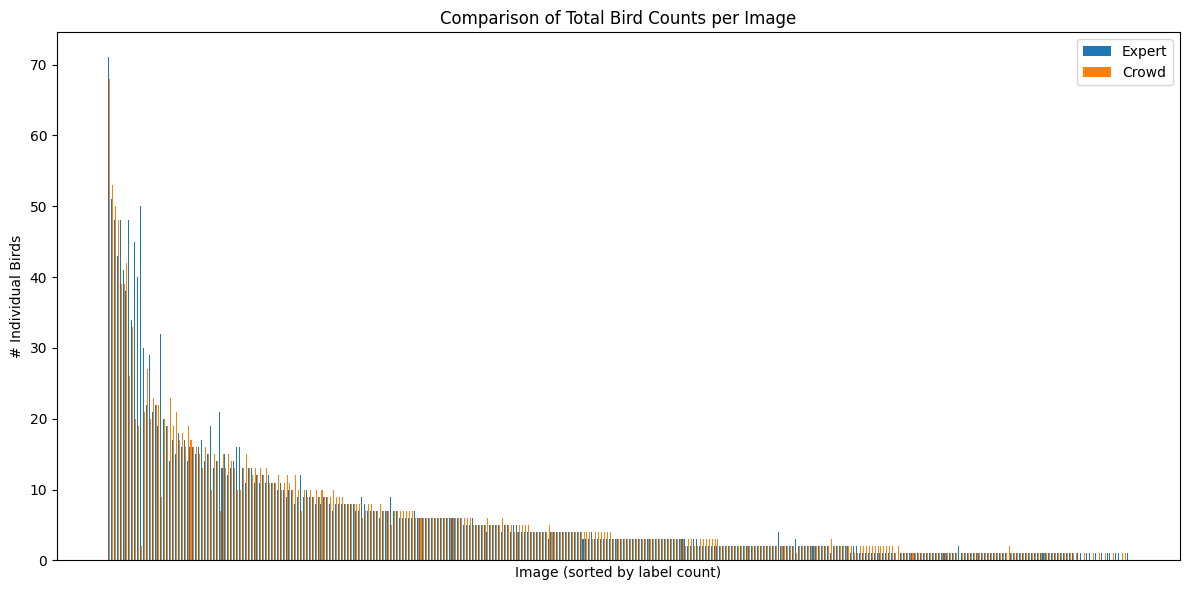

In [32]:
#DISPLAY OVERALL COUNT COMPARISONS

# Read the two CSV files
file1 = pd.read_csv(expert_labels_file)
file2 = pd.read_csv(crowd_labels_file)

# Group the data by filename and count the labels
grouped_file1 = file1.groupby('filename').size()
grouped_file2 = file2.groupby('filename').size()

# Get the unique filenames from both files
filenames = sorted(set(grouped_file1.index) | set(grouped_file2.index))

# Align the indices of grouped_file1 and grouped_file2 with filenames
grouped_file1 = grouped_file1.reindex(filenames, fill_value=0)
grouped_file2 = grouped_file2.reindex(filenames, fill_value=0)

# Sort the bars in descending order based on the label count
sorted_indices = np.argsort(grouped_file1 + grouped_file2)[::-1]
sorted_filenames = np.array(filenames)[sorted_indices]
sorted_grouped_file1 = grouped_file1.values[sorted_indices]
sorted_grouped_file2 = grouped_file2.values[sorted_indices]

# Set up the figure and axes for the bar chart
fig, ax = plt.subplots(figsize=(12, 6))
width = 0.35
index = np.arange(len(filenames))

# Plotting bars for the first file
p1 = ax.bar(index, sorted_grouped_file1, width, label='Expert')

# Calculate the position for the grouped bars
index2 = index + width

# Plotting bars for the second file
p2 = ax.bar(index2, sorted_grouped_file2, width, label='Crowd')

# Customizing the plot
ax.set_xlabel('Image (sorted by label count)')
ax.set_ylabel('# Individual Birds')
ax.set_title('Comparison of Total Bird Counts per Image')
ax.set_xticks([])  # Remove x-axis ticks and labels

ax.legend()

plt.tight_layout()
plt.show()




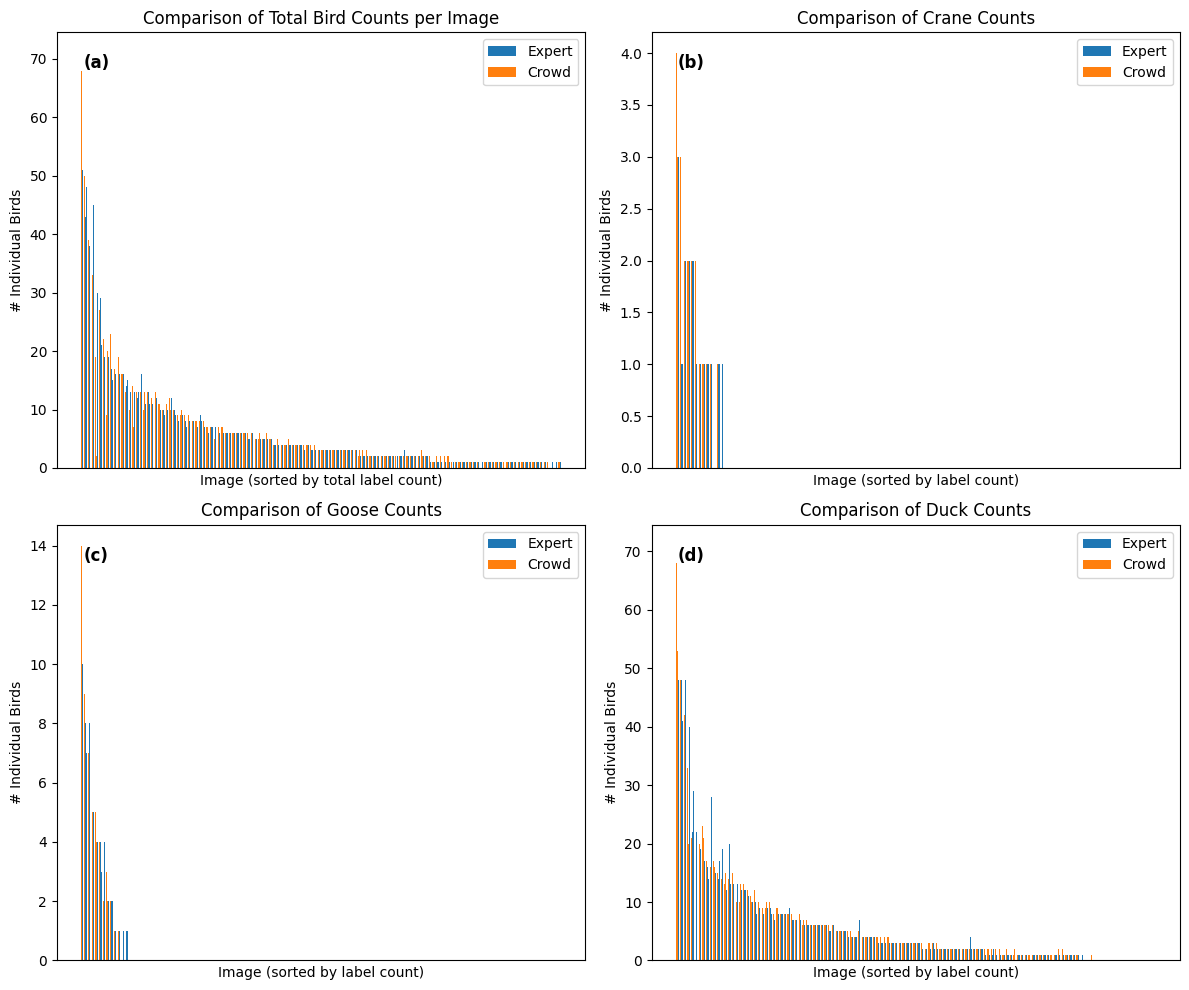

In [41]:
#DISPLAY COUNT COMPARISONS PER CLASS
import matplotlib.pyplot as plt
import numpy as np

# Define the class IDs you want to visualize
class_ids = [1, 2, 3]  # Modify with the desired class IDs

# Create a dictionary to map class IDs to labels
class_mapping = {1: 'Crane', 2: 'Goose', 3: 'Duck'}

# Set up the grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.subplots_adjust(hspace=0.4)  # Adjust the vertical spacing between subplots

# Calculate the total label count per image irrespective of class
total_counts_file1 = file1.groupby('filename').size()
total_counts_file2 = file2.groupby('filename').size()

# Get the unique filenames from both files
filenames = sorted(set(total_counts_file1.index) | set(total_counts_file2.index))

# Align the indices of total_counts_file1 and total_counts_file2 with filenames
total_counts_file1 = total_counts_file1.reindex(filenames, fill_value=0)
total_counts_file2 = total_counts_file2.reindex(filenames, fill_value=0)

# Sort the bars in descending order based on the total label count
sorted_indices_total = np.argsort(total_counts_file1 + total_counts_file2)[::-1]
sorted_filenames_total = np.array(filenames)[sorted_indices_total]
sorted_total_counts_file1 = total_counts_file1.values[sorted_indices_total]
sorted_total_counts_file2 = total_counts_file2.values[sorted_indices_total]

# Set up the subplot for the total label count
ax_total = axes[0, 0]

# Set the positions for the grouped bars
width_total = 0.35
index_total = np.arange(len(filenames))
index2_total = index_total + width_total

# Plotting grouped bars for the total label count
p_total1 = ax_total.bar(index_total, sorted_total_counts_file1, width_total, label='Expert')
p_total2 = ax_total.bar(index2_total, sorted_total_counts_file2, width_total, label='Crowd')

# Customizing the plot
ax_total.set_xlabel('Image (sorted by total label count)')
ax_total.set_ylabel('# Individual Birds')
ax_total.set_title('Comparison of Total Bird Counts per Image')
ax_total.set_xticks([])  # Remove x-axis ticks and labels

ax_total.legend()

# Iterate over the class IDs and generate a subplot for each
for i, class_id in enumerate(class_ids):
    # Filter the labels by class ID
    file1_filtered = file1[file1['class_id'] == class_id]
    file2_filtered = file2[file2['class_id'] == class_id]

    # Group the data by filename and count the labels
    grouped_file1 = file1_filtered.groupby('filename').size().reindex(filenames, fill_value=0)
    grouped_file2 = file2_filtered.groupby('filename').size().reindex(filenames, fill_value=0)

    # Sort the bars in descending order based on the label count
    sorted_indices = np.argsort(grouped_file1 + grouped_file2)[::-1]
    sorted_filenames = np.array(filenames)[sorted_indices]
    sorted_grouped_file1 = grouped_file1.values[sorted_indices]
    sorted_grouped_file2 = grouped_file2.values[sorted_indices]

    # Set up the subplot for the current class
    row = (i + 1) // 2
    col = (i + 1) % 2
    ax = axes[row, col]

    # Set the positions for the grouped bars
    width = 0.35
    index = np.arange(len(filenames))
    index2 = index + width

    # Plotting grouped bars for the first file
    p1 = ax.bar(index, sorted_grouped_file1, width, label='Expert')

    # Plotting grouped bars for the second file
    p2 = ax.bar(index2, sorted_grouped_file2, width, label='Crowd')

    # Customizing the plot
    ax.set_xlabel('Image (sorted by label count)')
    ax.set_ylabel('# Individual Birds')
    ax.set_title(f'Comparison of {class_mapping[class_id]} Counts')
    ax.set_xticks([])  # Remove x-axis ticks and labels

    ax.legend()

# Add subplot labels
subplot_labels = ['(a)', '(b)', '(c)', '(d)']
for i, ax in enumerate(axes.flat):
    ax.text(0.05, 0.95, subplot_labels[i], transform=ax.transAxes, fontsize=12, fontweight='bold', va='top')


plt.tight_layout()
plt.show()


In [ ]:
#STATISTICS ON CONSENSUS COUNTS

# Group the data by filename and count the labels for each file
grouped_file1 = file1.groupby('filename').size()
grouped_file2 = file2.groupby('filename').size()

# Calculate the difference in label counts per image
difference = grouped_file2 - grouped_file1

# Calculate overall statistics on the difference
overall_mean = difference.mean()
overall_median = difference.median()
overall_min = difference.min()
overall_max = difference.max()
overall_std = difference.std()

# Calculate class-wise statistics on the difference
class_difference = file2.groupby(['filename', 'class_id']).size() - file1.groupby(['filename', 'class_id']).size()
class_means = class_difference.groupby('class_id').mean()
class_medians = class_difference.groupby('class_id').median()
class_mins = class_difference.groupby('class_id').min()
class_maxs = class_difference.groupby('class_id').max()
class_stds = class_difference.groupby('class_id').std()

# Print overall statistics
print("Overall Statistics:")
print(f"Mean: {overall_mean}")
print(f"Median: {overall_median}")
print(f"Min: {overall_min}")
print(f"Max: {overall_max}")
print(f"Standard Deviation: {overall_std}")
print()

# Print class-wise statistics
print("Class-wise Statistics:")
for class_id in class_means.index:
    print(f"Class ID: {class_id}")
    print(f"Mean: {class_means[class_id]}")
    print(f"Median: {class_medians[class_id]}")
    print(f"Min: {class_mins[class_id]}")
    print(f"Max: {class_maxs[class_id]}")
    print(f"Standard Deviation: {class_stds[class_id]}")
    print()
